In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

load = False  # should stored weights be loaded from the disk?
train = True  # should the model be trained? 
export = True # should the weights be exported? 

In [28]:
class AE_MNIST(keras.Model):
    '''
    This class represents the autoencoder (not variational!) as it is proposed in
    "Generative Adversarial Networks with Decoder-Encoder Output Noise", Table 2.
    
    The paper was written by: Guoqiang Zhong, Member, IEEE, Wei Gao, Yongbin Liu, 
    Youzhao Yang
    '''
    def __init__(self, latent_dim, path="vae_save", load=False, **kwargs):
        super(AE_MNIST, self).__init__(**kwargs)
        
        self.path = path
        self.load = load
        
        self.encoder = self.build_encoder(latent_dim)
        self.decoder = self.build_decoder(latent_dim)
    
    def export(self):
        self.encoder.save(f"{self.path}/encoder_weights.h5")
        self.decoder.save(f"{self.path}/decoder_weights.h5")
    
    def build_decoder(self, latent_dim):
        '''
        Build the encoder network. 
        '''
        latent_inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(128, activation="relu")(latent_inputs)
        x = layers.Dense(784, activation="relu")(x)
        x = layers.Reshape((28,28,1))(x)
        
        x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2DTranspose(1, 5, activation="sigmoid", padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dense(784)(x)
        x = layers.Reshape((28,28,1))(x)
        
        decoder = keras.Model(latent_inputs, x, name="decoder")
        # decoder.summary()

        if self.load:
            decoder.load_weights(f"{self.path}/decoder_weights.h5")
        
        return decoder
    
    def build_encoder(self, latent_dim):
        encoder_inputs = keras.Input(shape=(28, 28, 1))
        x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation="relu")(x)
        
        encoder = keras.Model(encoder_inputs, x, name="encoder")
        # encoder.summary()

        if self.load:
            encoder.load_weights(f"{self.path}vae_save/encoder_weights.h5")
        
        return encoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            encoded = self.encoder(data)
            reconstruction = self.decoder(encoded)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss
        }


In [29]:
# load the MNIST data and merge training and test data
(x_train, y_train), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [30]:
# initialize the autoencoder and give it a path where to store images and its model
vae = AE_MNIST(128, path="ae_degan_mnist", load=load)
vae.compile(optimizer=keras.optimizers.Adam())

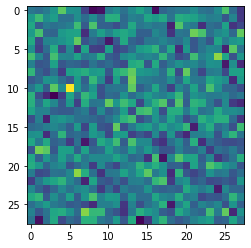

In [31]:
import matplotlib.pyplot as plt

image = mnist_digits[0].reshape(-1, 28, 28, 1)

plt.imshow(image.reshape(28,28))

encoded = vae.encoder.predict(image)
decoded = vae.decoder.predict(encoded)

plt.imshow(decoded.reshape(28,28))

In [ ]:
# training
if train:
    vae.export()
    
    while True:
        vae.fit(mnist_digits, epochs=1, batch_size=128)
        vae.export()
        

110/547 [=====>........................] - ETA: 24:34 - loss: 2604.7349 - reconstruction_loss: 2604.7349